In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import erf, load_image, straighten, ImageQuant2
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
# Default model
thickness = 50
sigma = 1.5
membg0 = np.exp(-((np.arange(thickness) - thickness / 2) ** 2) / (2 * sigma ** 2))
cytbg0 = (1 + erf((np.arange(thickness) - thickness / 2) / sigma)) / 2
cal0 = np.loadtxt('../../Run/Quantification model calibration/optogenetics_factors.txt')[0]

# Learnt model
membg1 = np.loadtxt('../../Run/Quantification model calibration/membg6.txt')
cytbg1 = np.loadtxt('../../Run/Quantification model calibration/cytbg.txt')
cal1 = np.loadtxt('../../Run/Quantification model calibration/optogenetics_factors.txt')[6]

noise = 700

### Straightened image

In [3]:
df = pd.read_csv('../../Run/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
path = df[df.Line == 'nwg338'].Path.iloc[0]

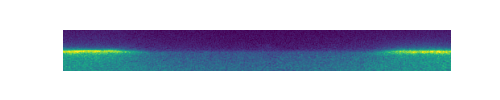

In [4]:
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI_fit.txt')
straight = straighten(img, roi, 50)

fig, ax = plt.subplots()
vmax = np.percentile(straight, 99.9)
ax.imshow(straight, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
fig.set_size_inches(5, 1)
fig.savefig('Figs/truth.png', dpi=600, transparent=True)

### Quantification 0

In [5]:
iq0 = ImageQuant2(img=img, roi=roi, cytbg=cytbg0, membg=membg0, pooling_rate=1)
iq0.quantify()
iq0.mems[0]*= cal0

100%|██████████| 600/600 [00:05<00:00, 118.36it/s]


### Quantification 1

In [6]:
iq1 = ImageQuant2(img=img, roi=roi, cytbg=cytbg1, membg=membg1, pooling_rate=1)
iq1.quantify()
iq1.mems[0]*= cal1

100%|██████████| 600/600 [00:04<00:00, 125.81it/s]


### Figure: membrane concentration

In [7]:
# fig, ax = plt.subplots()
# ax.plot(iq0.mems[0])
# ax.plot(iq1.mems[0])
# ax.set_ylabel('Concentration\n(a.u.)')
# ax.set_xticks([0, len(iq0.mems[0])])
# ax.set_xticklabels(['0', 'p'])
# ax.set_yticks([])
# ax.set_ylim(bottom=0)
# ax.tick_params(axis='both', labelsize=8)
# # fig.set_size_inches(1.5,1.5)
# # ax.set_ylim(bottom=0)
# # fig.subplots_adjust(left=0.25, bottom=0.25)

### Simulation 0

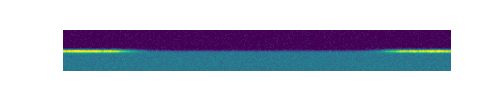

In [8]:
fig, ax = plt.subplots()
sim0 = iq0.straight_images_sim[0] + np.random.normal(scale=noise, size=iq0.straight_images_sim[0].shape)
ax.imshow(sim0, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
fig.set_size_inches(5, 1)
fig.savefig('Figs/model0.png', dpi=600, transparent=True)

### Simulation 1

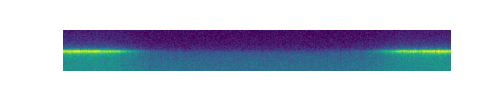

In [9]:
fig, ax = plt.subplots()
sim1 = iq1.straight_images_sim[0] + np.random.normal(scale=noise, size=iq1.straight_images_sim[0].shape)
ax.imshow(sim1, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
fig.set_size_inches(5, 1)
fig.savefig('Figs/model1.png', dpi=600, transparent=True)

### Patches

In [10]:
patch = (50, 120)
zT = straight[:, patch[0]:patch[1]]

z0_noise = sim0[:, patch[0]:patch[1]]
z1_noise = sim1[:, patch[0]:patch[1]]

z0 = iq0.straight_images_sim[0][:, patch[0]:patch[1]]
z1 = iq1.straight_images_sim[0][:, patch[0]:patch[1]]

In [11]:
### Metrics
norm = np.percentile(zT, 99.9)

rmse0 = np.sqrt(np.mean((zT/norm-z0/norm)**2))
rmse1 = np.sqrt(np.mean((zT/norm-z1/norm)**2))

print(rmse0)
print(rmse1)

0.10955542
0.048855368


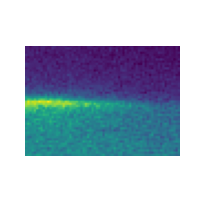

In [12]:
fig, ax = plt.subplots()
ax.imshow(zT, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
fig.set_size_inches(2,2)
fig.savefig('Figs/truth_zoom.png', dpi=600, transparent=True)

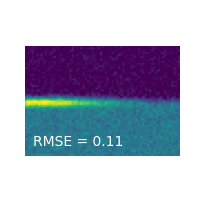

In [13]:
fig, ax = plt.subplots()
ax.imshow(z0_noise, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
ax.text(s='RMSE = %.2f' % rmse0, x=3, y=45, color='w', fontsize=10)
fig.set_size_inches(2,2)
fig.savefig('Figs/model0_zoom.png', dpi=600, transparent=True)

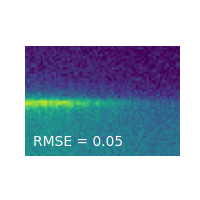

In [14]:
fig, ax = plt.subplots()
ax.imshow(z1_noise, vmin=0, vmax=vmax, cmap='viridis')
ax.axis('off')
ax.text(s='RMSE = %.2f' % rmse1, x=3, y=45, color='w', fontsize=10)
fig.set_size_inches(2,2)
fig.savefig('Figs/model1_zoom.png', dpi=600, transparent=True)